In [23]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt
from typing import Any, List
import pandas as pd
from tqdm import tqdm

# DL library imports
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torch.utils.data.sampler import SubsetRandomSampler
from torch import nn, optim
import torch.nn.functional as F

In [24]:
!pip install thop

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## 1 — **Dataset**: Download and use the German Traffic Sign Recognition Benchmark

Traffic sign detection and classification is an important task in the perception stack of an autonomous vehicle. In this notebook, we are implementing a model to perform traffic sign classification with the Garden Traffic Sign Benchmark dataset. This is a multi-class, single-image classification challenge held at the International Joint Conference on Neural Networks (IJCNN) 2011. The dataset has the following features 
- More than 40 classes
- More than 50,000 images in total
- Large, lifelike database

In [25]:
classes = ['Speed limit (20km/h)', 'Speed limit (30km/h)', 'Speed limit (50km/h)', 'Speed limit (60km/h)', 'Speed limit (70km/h)', 'Speed limit (80km/h)', 'End of speed limit (80km/h)', 'Speed limit (100km/h)', 'Speed limit (120km/h)', 'No passing', 'No passing veh over 3.5 tons', 'Right-of-way at intersection', 'Priority road', 'Yield', 'Stop', 'No vehicles', 'Veh > 3.5 tons prohibited', 'No entry', 'General caution', 'Dangerous curve left', 'Dangerous curve right', 'Double curve', 'Bumpy road', 'Slippery road', 'Road narrows on the right', 'Road work', 'Traffic signals', 'Pedestrians', 'Children crossing', 'Bicycles crossing', 'Beware of ice/snow', 'Wild animals crossing', 'End speed + passing limits', 'Turn right ahead', 'Turn left ahead', 'Ahead only', 'Go straight or right', 'Go straight or left', 'Keep right', 'Keep left', 'Roundabout mandatory', 'End of no passing', 'End no passing veh > 3.5 tons']

In [26]:
# necessary image transform i.e. convert to Tensor, normalize
train_transform = transforms.Compose([transforms.Resize([112,112]), transforms.ToTensor()])
test_transform  = transforms.Compose([transforms.Resize([112,112]), transforms.ToTensor()])

# Download the Train and Test set
train_set = datasets.GTSRB('.',split='train', download=True, transform=train_transform)
test_set = datasets.GTSRB('.', split='test', download=True, transform=test_transform)

### Define HyperParameters

In [27]:
NUM_CLASSES = len(classes)
NUM_WORKERS = 1 
TEST_BATCH_SIZE  = 128
TRAIN_BATCH_SIZE = 64
VALID_SIZE = 0.2 

### Train/Test Split

In [28]:
len_train_set = len(train_set)
index_list = list(range(len_train_set))
np.random.shuffle(index_list)
split_index = int(len_train_set * VALID_SIZE)
train_idx, valid_idx = index_list[split_index:], index_list[:split_index]
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

### DataLoader

In [29]:
train_loader = DataLoader(train_set, batch_size=TRAIN_BATCH_SIZE, sampler=train_sampler, num_workers=NUM_WORKERS)
valid_loader = DataLoader(train_set, batch_size=TEST_BATCH_SIZE,  sampler=valid_sampler, num_workers=NUM_WORKERS)
test_loader  = DataLoader(test_set,  batch_size=TEST_BATCH_SIZE,  shuffle=True,num_workers=NUM_WORKERS)

## 2 — **Network**: Define a custom neural net and measure the metrics

- We'll use a simple convolutional network model that takes in the image and outputs probabilities for each of 43 classes.
- The model is created in the `model.py` file. In Pytorch, we can create the Neural Network model by defining a custom class (inherits from [nn.Module](https://pytorch.org/docs/stable/generated/torch.nn.Module.html)).
- The `forward` function in the class defines the forward pass of the network.

In [30]:
from model import ConvNet
# Import and Load the Model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ConvNet(NUM_CLASSES).to(device)
model

ConvNet(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (conv2): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=12544, out_features=1000, bias=True)
  (fc2): Linear(in_features=1000, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=43, bias=True)
)

In [31]:
from modelMetrics import computeInferenceTime, getModelFileSize, profile, getModelSize

def print_model_metrics(model, input):
  print("Model Size: ", str(round(getModelSize(model),3)),"Mb")
  print("File Size: ", str(round(getModelFileSize(model),3)),"Mb")
  print("Inference Time: ",str(round(computeInferenceTime(model,input, device),5)),"s")
  macs, params = profile(model, inputs=(input,), verbose=False)
  flops = 2 * macs
  print("Mega FLOPS: ", str(flops * 1e-6))
  print("Mega MACs: ", str(macs * 1e-6))
  print("Mega Params: ", str(params * 1e-6))

#### Print the Model Sparsity

- Model sparsity refers to the ratio of parameters with zero weights to the total number of parameters. 
- Eg : If a linear layer with 100 neurons and 25 of the neurons have been pruned (effectively set to zero) then the sparsity of the layer is 25%.
- Sparsity can be calculated for each layers and for the entire model as well (referred to as Global sparsity)


In [32]:
def get_model_sparsity(model):
    totalElements = 0
    totalZeroElements = 0
    for name, module in model.named_children():
        numElementsInLayer = float(module.weight.nelement())
        numZeroElementsInLayer = float(torch.sum(module.weight == 0))
        layerWeightSparsity = 100.0 * (numZeroElementsInLayer/ numElementsInLayer)
        print(f"Sparsity in {name}.weight: {layerWeightSparsity}%.")
        
        totalElements += numElementsInLayer
        totalZeroElements += numZeroElementsInLayer
    
    if totalElements > 0 :
        globalWeightSparsity = 100.0 * (totalZeroElements / totalElements)
    else:
        globalWeightSparsity = 0.0
    return globalWeightSparsity
    
sparsity = get_model_sparsity(model)
print(f"Global Sparsity (weight): {sparsity}%")

Sparsity in conv1.weight: 0.0%.
Sparsity in conv2.weight: 0.0%.
Sparsity in conv3.weight: 0.0%.
Sparsity in conv4.weight: 0.0%.
Sparsity in conv5.weight: 0.0%.
Sparsity in fc1.weight: 0.0%.
Sparsity in fc2.weight: 0.0%.
Sparsity in fc3.weight: 0.0%.
Global Sparsity (weight): 0.0%


## 3 - **Training**: Train the model on the dataset, and record the accuracy metrics

Before we train our model, we'll define some helper functions to calculate metric, plot training results etc

In [33]:
from sklearn.metrics import accuracy_score

class meanClassificationAccuracyMetric:
    """ Class to find the avg accuracy of softmax predictions to ground truth label """    
    def __init__(self):
        self.batchAccuracies = []
        self.meanClassificationAccuracy = 0.0

    def update(self, y_preds: torch.Tensor, labels: torch.Tensor):
        # predicted output class
        modelPredictions = np.argmax(torch.softmax(y_preds, axis=1).numpy(), axis=1)
        self.batchAccuracies.append(accuracy_score(labels.numpy(), modelPredictions))

    def compute(self):
        self.meanClassificationAccuracy = np.mean(self.batchAccuracies) * 100.0
        return self.meanClassificationAccuracy

In [34]:
def plotTrainingResults(df, model_name):
    fig, ax1 = plt.subplots(figsize=(10,4))
    ax1.set_ylabel('trainLoss', color='tab:red')
    ax1.plot(df['epoch'].values, df['trainLoss'].values, color='tab:red')
    ax1.tick_params(axis='y', labelcolor='tab:red')

    ax2 = ax1.twinx()  
    ax2.set_ylabel('validationLoss', color='tab:blue')
    ax2.plot(df['epoch'].values, df['validationLoss'].values, color='tab:blue')
    ax2.tick_params(axis='y', labelcolor='tab:blue')

    plt.suptitle(f'{model_name} Training, Validation Curves')
    plt.show()

In [35]:
def trainValidateModel(model, criterion, optimizer, dataloader_train, 
                       dataloader_valid, metricClass, metricName, device):
    results = []    
    min_val_loss = np.Inf
    len_train_loader = len(dataloader_train)

    # move model to target device
    model.to(device)
    
    for epoch in range(N_EPOCHS):
        print(f"Starting {epoch + 1} epoch ...")
        
        # Training
        model.train()
        train_loss = 0.0
        for i, (inputs, labels) in tqdm(enumerate(dataloader_train), total=len_train_loader):
            inputs = inputs.to(device)
            labels = labels.to(device)  

            # Forward pass
            y_preds = model(inputs)
            loss = criterion(y_preds, labels)
            train_loss += loss.item()
              
            # Backward pass
            loss.backward()
            optimizer.step()
            optimizer.zero_grad() 
            
        # Validate
        model.eval()
        validation_loss = 0.0
        metric_object = metricClass()

        with torch.no_grad():
            for inputs, labels in dataloader_valid:
                inputs = inputs.to(device)
                labels = labels.to(device)                
                y_preds = model(inputs)
            
                # calculate loss
                loss = criterion(y_preds, labels)
                validation_loss += loss.item()

                # update batch metric information            
                metric_object.update(y_preds.cpu().detach(), labels.cpu().detach())

        # compute per batch losses, metric value
        train_loss = train_loss / len(dataloader_train)
        validation_loss = validation_loss / len(dataloader_valid)
        validationMetric = metric_object.compute()

        print(f'Epoch: {epoch+1}, trainLoss:{train_loss:6.5f}, validationLoss:{validation_loss:6.5f}, {metricName}:{validationMetric: 4.2f}%')
        
        # store results
        results.append({'epoch': epoch, 'trainLoss': train_loss, 
                        'validationLoss': validation_loss, f'{metricName}': validationMetric})
        
        # if validation loss has decreased, save model and reset variable
        if validation_loss <= min_val_loss:
            min_val_loss = validation_loss
            torch.save(model.state_dict(), "ConvNet.pt")

    # plot results
    results = pd.DataFrame(results)
    plotTrainingResults(results, "ConvNet")
    return results

Starting 1 epoch ...


100%|██████████| 333/333 [00:21<00:00, 15.78it/s]


Epoch: 1, trainLoss:32.94041, validationLoss:3.49623, accuracy: 4.99%
Starting 2 epoch ...


100%|██████████| 333/333 [00:14<00:00, 23.01it/s]


Epoch: 2, trainLoss:3.41650, validationLoss:3.36740, accuracy: 8.97%
Starting 3 epoch ...


100%|██████████| 333/333 [00:14<00:00, 22.94it/s]


Epoch: 3, trainLoss:3.34104, validationLoss:3.17565, accuracy: 12.68%
Starting 4 epoch ...


100%|██████████| 333/333 [00:14<00:00, 22.84it/s]


Epoch: 4, trainLoss:2.34510, validationLoss:1.59284, accuracy: 46.69%
Starting 5 epoch ...


100%|██████████| 333/333 [00:14<00:00, 22.72it/s]


Epoch: 5, trainLoss:1.30912, validationLoss:1.10555, accuracy: 63.97%
Starting 6 epoch ...


100%|██████████| 333/333 [00:15<00:00, 21.59it/s]


Epoch: 6, trainLoss:0.93549, validationLoss:0.94504, accuracy: 69.39%
Starting 7 epoch ...


100%|██████████| 333/333 [00:14<00:00, 22.66it/s]


Epoch: 7, trainLoss:0.80356, validationLoss:0.80526, accuracy: 72.47%
Starting 8 epoch ...


100%|██████████| 333/333 [00:14<00:00, 22.70it/s]


Epoch: 8, trainLoss:0.69681, validationLoss:0.76182, accuracy: 75.34%
Starting 9 epoch ...


100%|██████████| 333/333 [00:14<00:00, 22.80it/s]


Epoch: 9, trainLoss:0.64023, validationLoss:0.64008, accuracy: 79.25%
Starting 10 epoch ...


100%|██████████| 333/333 [00:14<00:00, 23.11it/s]


Epoch: 10, trainLoss:0.59480, validationLoss:0.58771, accuracy: 81.57%
Starting 11 epoch ...


100%|██████████| 333/333 [00:14<00:00, 22.85it/s]


Epoch: 11, trainLoss:0.56146, validationLoss:0.64940, accuracy: 79.95%
Starting 12 epoch ...


100%|██████████| 333/333 [00:14<00:00, 22.73it/s]


Epoch: 12, trainLoss:0.52886, validationLoss:0.57560, accuracy: 81.80%
Starting 13 epoch ...


100%|██████████| 333/333 [00:15<00:00, 21.68it/s]


Epoch: 13, trainLoss:0.50662, validationLoss:0.53811, accuracy: 83.53%
Starting 14 epoch ...


100%|██████████| 333/333 [00:14<00:00, 22.80it/s]


Epoch: 14, trainLoss:0.47753, validationLoss:0.60497, accuracy: 80.89%
Starting 15 epoch ...


100%|██████████| 333/333 [00:14<00:00, 22.64it/s]


Epoch: 15, trainLoss:0.46283, validationLoss:0.49243, accuracy: 84.42%


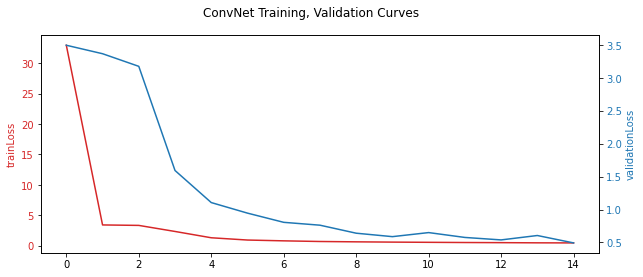

In [38]:
# Hyper parameters for training model
N_EPOCHS = 15
LR = 0.01

# Define the Loss
criterion = nn.CrossEntropyLoss()

# Define the Optimizer
optimizer = optim.Adam(model.parameters(), lr=LR)

# train, validate standard model
modelResults = trainValidateModel(model, criterion, optimizer, train_loader, valid_loader, meanClassificationAccuracyMetric, 'accuracy', device)

In [39]:
def evaluteOnTestData(model, pretrainedModelPath, device, 
                     dataloader_test, metricClass, metricName, modelName):
    testSetMetric = 0.0
    if pretrainedModelPath is not None:
        if os.path.isfile(pretrainedModelPath) == True:
            model.load_state_dict(torch.load(pretrainedModelPath, map_location=device))

    model.to(device)
    model.eval()
    metricObject = metricClass()

    with torch.no_grad():
      for inputs, labels in tqdm(dataloader_test, total=len(dataloader_test)):
        inputs = inputs.to(device)
        labels = labels.to(device)
        y_preds = model(inputs)
            
        # update batch metric information            
        metricObject.update(y_preds.cpu().detach(), labels.cpu().detach())

    testSetMetric = metricObject.compute()    
    print(f'\n{modelName} has {testSetMetric} {metricName} on testData')
    return testSetMetric

In [40]:
testSetMetric = evaluteOnTestData(model, "./ConvNet.pt", device, test_loader, 
                    meanClassificationAccuracyMetric, "Test_Accuracy", "Custom_ConvNet")

100%|██████████| 99/99 [00:08<00:00, 11.65it/s]


Custom_ConvNet has 77.17931495184402 Test_Accuracy on testData


## 4 - **Pruning**: Apply different Pruning techniques on the model

Now that we understand the pruning APIs in Pytorch, we'll use them to 
prune our custom MLP model. In the next section, we'll do the following:

- Apply the Unstructured pruning we learned above and also the Global version of it along with structured pruning on our trained model
- Observe the Accuracy of both the pruned model on Test set
- Apply different levels of Pruning percentages (*read sparsity levels*) and observe the different in performance metric

In [41]:
import torch.nn.utils.prune as prune

In [42]:
# Let's use different pruning percentages for each technique
prunePercentages = np.linspace(0.05, 0.90, 8).tolist()
print([round(x,3) for x in prunePercentages])

[0.05, 0.171, 0.293, 0.414, 0.536, 0.657, 0.779, 0.9]


### Layerwise Unstructured Pruning

In [70]:
def layer_unstructured_prune(model:nn.Module, prunePercentage:float):
    for name, module in model.named_modules():
        if isinstance(module, torch.nn.Linear) or isinstance(module, torch.nn.Conv2d):
            prune.l1_unstructured(module, name='weight', amount=prunePercentage)
    return model

In [71]:
# placeholder to store results
l1_unstructured_accuracies = []

# iterate through each prune percentage
for perc in prunePercentages:
    # load the pretrained model
    model = ConvNet(NUM_CLASSES).to(device)
    model.load_state_dict(torch.load("./ConvNet.pt"))

    # prune the model
    unStructuredPruneModel = layer_unstructured_prune(model, perc)

    # evaluate the pruned model on test data
    l1_unstructured_accuracies.append(evaluteOnTestData(unStructuredPruneModel, None, \
          device, test_loader, meanClassificationAccuracyMetric, "Test accuracy", "Unstructured Prune"))    

100%|██████████| 99/99 [00:08<00:00, 11.66it/s]



Unstructured Prune has 77.17179058022083 Test accuracy on testData


100%|██████████| 99/99 [00:09<00:00, 10.93it/s]



Unstructured Prune has 76.76272169368099 Test accuracy on testData


100%|██████████| 99/99 [00:08<00:00, 11.74it/s]



Unstructured Prune has 75.12002290345315 Test accuracy on testData


100%|██████████| 99/99 [00:08<00:00, 11.58it/s]



Unstructured Prune has 75.81042988019733 Test accuracy on testData


100%|██████████| 99/99 [00:08<00:00, 11.81it/s]



Unstructured Prune has 72.14551033591732 Test accuracy on testData


100%|██████████| 99/99 [00:09<00:00, 10.84it/s]



Unstructured Prune has 45.123656624383365 Test accuracy on testData


100%|██████████| 99/99 [00:10<00:00,  9.71it/s]



Unstructured Prune has 40.12820795160912 Test accuracy on testData


100%|██████████| 99/99 [00:08<00:00, 11.35it/s]


Unstructured Prune has 39.38292811839324 Test accuracy on testData


### Layerwise structured pruning

In [72]:
def layer_structured_prune(model:nn.Module, prunePercentage:float):
    for name, module in model.named_modules():
        if isinstance(module, torch.nn.Linear) or isinstance(module, torch.nn.Conv2d):
            prune.ln_structured(module, name='weight', amount=prunePercentage, n=1, dim=0)
    return model

In [73]:
# placeholder to store results
l1_structured_accuracies = []

# iterate through each prune percentage
for perc in prunePercentages:
    # load the pretrained model
    model = ConvNet(NUM_CLASSES).to(device)
    model.load_state_dict(torch.load("./ConvNet.pt"))

    # prune the model
    structuredPruneModel = layer_structured_prune(model, perc)

    # evaluate the pruned model on test data
    l1_structured_accuracies.append(evaluteOnTestData(structuredPruneModel, None, \
          device, test_loader, meanClassificationAccuracyMetric, "Test accuracy", "structured Prune"))

100%|██████████| 99/99 [00:09<00:00, 10.25it/s]



structured Prune has 71.87353182992719 Test accuracy on testData


100%|██████████| 99/99 [00:08<00:00, 11.63it/s]



structured Prune has 53.882759278834854 Test accuracy on testData


100%|██████████| 99/99 [00:08<00:00, 11.71it/s]



structured Prune has 36.88520378200611 Test accuracy on testData


100%|██████████| 99/99 [00:08<00:00, 11.59it/s]



structured Prune has 20.465006166314307 Test accuracy on testData


100%|██████████| 99/99 [00:08<00:00, 11.71it/s]



structured Prune has 9.248003288700964 Test accuracy on testData


100%|██████████| 99/99 [00:08<00:00, 11.71it/s]



structured Prune has 8.617057199906037 Test accuracy on testData


100%|██████████| 99/99 [00:09<00:00, 10.88it/s]



structured Prune has 3.4562558726802917 Test accuracy on testData


100%|██████████| 99/99 [00:09<00:00, 10.66it/s]


structured Prune has 3.5549903100775193 Test accuracy on testData


### Global Unstructured Pruning

In [74]:
def global_unstructured_prune(model:nn.Module, prunePercentage:float):
    parameters_to_prune = []
    for name, module in model.named_modules():
        if isinstance(module, torch.nn.Linear) or isinstance(module, torch.nn.Conv2d):
            parameters_to_prune.append((module, 'weight'))
    prune.global_unstructured(parameters_to_prune, pruning_method=prune.L1Unstructured, amount=prunePercentage)
    return model

In [75]:
# placeholder to store results
global_prune_accuracies = []

# iterate through each prune percentage
for perc in prunePercentages:
    # load the pretrained model
    model = ConvNet(NUM_CLASSES).to(device)
    model.load_state_dict(torch.load("./ConvNet.pt"))

    # prune the model
    globalPruneModel = global_unstructured_prune(model, perc)

    # evaluate the pruned model on test data
    global_prune_accuracies.append(evaluteOnTestData(globalPruneModel, None, \
          device, test_loader, meanClassificationAccuracyMetric, "Test accuracy", "structured Prune"))    

100%|██████████| 99/99 [00:08<00:00, 11.53it/s]



structured Prune has 77.1367380197322 Test accuracy on testData


100%|██████████| 99/99 [00:08<00:00, 11.53it/s]



structured Prune has 77.06920219638243 Test accuracy on testData


100%|██████████| 99/99 [00:08<00:00, 11.75it/s]



structured Prune has 76.8796247357294 Test accuracy on testData


100%|██████████| 99/99 [00:08<00:00, 11.63it/s]



structured Prune has 75.77133985200845 Test accuracy on testData


100%|██████████| 99/99 [00:08<00:00, 11.68it/s]



structured Prune has 75.34116602067184 Test accuracy on testData


100%|██████████| 99/99 [00:08<00:00, 11.68it/s]



structured Prune has 74.63093874794455 Test accuracy on testData


100%|██████████| 99/99 [00:08<00:00, 11.57it/s]



structured Prune has 74.61166901573878 Test accuracy on testData


100%|██████████| 99/99 [00:08<00:00, 11.63it/s]


structured Prune has 73.89299976509278 Test accuracy on testData


## 5 - **Analysis**: Visualize the results and find the best!


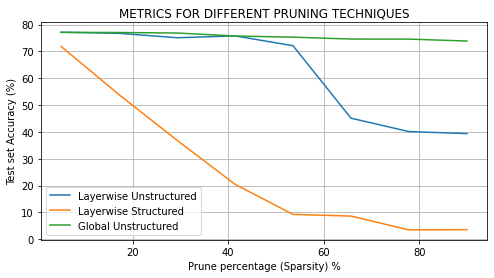

In [76]:
fig, ax = plt.subplots(1,1,figsize=(8,4))
ax.plot(np.array(prunePercentages) * 100.0, np.array(l1_unstructured_accuracies), label='Layerwise Unstructured')
ax.plot(np.array(prunePercentages) * 100.0, np.array(l1_structured_accuracies), label='Layerwise Structured')
ax.plot(np.array(prunePercentages) * 100.0, np.array(global_prune_accuracies), label='Global Unstructured')
ax.set(xlabel ='Prune percentage (Sparsity) %', ylabel = 'Test set Accuracy (%)', title = 'METRICS FOR DIFFERENT PRUNING TECHNIQUES')
ax.legend()
ax.grid(True)
plt.show()

—— Observations

 - We can observe that even at ~55% Sparsity, layer wise unstructured pruning techniques maintain ~75% test accuracy.
 - Beyond a threshold (60% in our case), test accuracy drops significantly for all 3 techniques indicating the model is not able to capture enough information with the remaining weights
 - At least in our case, structured pruning is worse than unstructured pruning. 

### Model Metrics

#### Before Pruning

In [77]:
model = ConvNet(NUM_CLASSES).to(device)
model.load_state_dict(torch.load("./ConvNet.pt"))

random_input = torch.rand(3, 3, 112, 112).to(device)
print_model_metrics(model, random_input)

Model Size:  57.464 Mb
File Size:  60.26 Mb
Inference Time:  0.00076 s
Mega FLOPS:  3147.1856639999996
Mega MACs:  1573.5928319999998
Mega Params:  15.063891


#### Unstructured

In [80]:
model = ConvNet(NUM_CLASSES).to(device)
model.load_state_dict(torch.load("./ConvNet.pt"))
unStructuredPruneModel = layer_unstructured_prune(model, 0.5)

random_input = torch.rand(3, 3, 112, 112).to(device)
print_model_metrics(unStructuredPruneModel, random_input)

Model Size:  114.919 Mb
File Size:  120.508 Mb
Inference Time:  0.00097 s
Mega FLOPS:  3147.1856639999996
Mega MACs:  1573.5928319999998
Mega Params:  15.063891


#### Structured

In [81]:
model = ConvNet(NUM_CLASSES).to(device)
model.load_state_dict(torch.load("./ConvNet.pt"))
StructuredPruneModel = layer_structured_prune(model, 0.1)

print_model_metrics(StructuredPruneModel, random_input)

Model Size:  114.919 Mb
File Size:  120.508 Mb
Inference Time:  0.00097 s
Mega FLOPS:  3147.1856639999996
Mega MACs:  1573.5928319999998
Mega Params:  15.063891


### Global

In [82]:
model = ConvNet(NUM_CLASSES).to(device)
model.load_state_dict(torch.load("./ConvNet.pt"))
globalPruneModel = global_unstructured_prune(model, 0.9414)

print_model_metrics(globalPruneModel, random_input)

Model Size:  114.919 Mb
File Size:  120.508 Mb
Inference Time:  0.00096 s
Mega FLOPS:  3147.1856639999996
Mega MACs:  1573.5928319999998
Mega Params:  15.063891


**Now, let's plot all 4 layers of our custom model and see how different techiques have pruned weights**

In [63]:
import matplotlib
import matplotlib.patches as mpatches

binary_cmap = matplotlib.colors.ListedColormap(['#3D99FF', '#7F7F7F'])
patchList = []
for lab,c in zip([False, True], ['#3D99FF', '#7F7F7F']):
    patchList.append(mpatches.Patch(color=c, label=lab))

def plot_tensor_mask(pt_tensor, ax=None):
  z_np = pt_tensor.detach().cpu().numpy()
  ln = ax.imshow(z_np, cmap = binary_cmap)
  ax.axis('off')
  return ln

In [56]:
def plot_custom_model(model, title=''):
  fig, axes = plt.subplots(1,4,figsize=(16, 4), gridspec_kw={'width_ratios': [7,5,3,1]})

  model_masks = dict(model.named_buffers())
  plot_tensor_mask(model_masks['conv1.weight_mask'], axes[0])
  plot_tensor_mask(model_masks['conv2.weight_mask'], axes[1])
  plot_tensor_mask(model_masks['conv3.weight_mask'], axes[2])
  plot_tensor_mask(model_masks['conv4.weight_mask'], axes[3])
  
  axes[0].set_title('FC Layer1')
  axes[1].set_title('FC Layer2')
  axes[2].set_title('FC Layer3')
  axes[3].set_title('FC Layer4')
  
  if title is not '':
    plt.suptitle(title)

KeyError: ignored

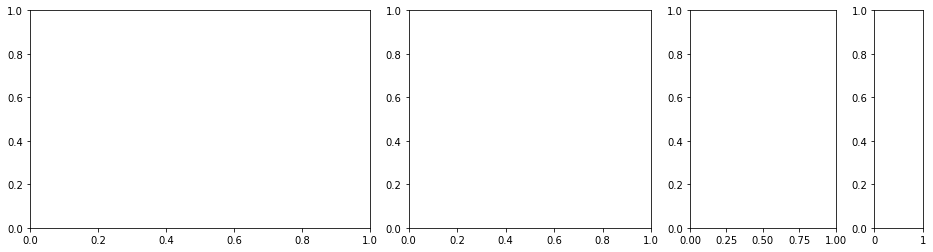

In [57]:
plot_custom_model(unStructuredPruneModel, title='Unstructured Pruned Model')

In [ ]:
plot_custom_model(structuredPruneModel, title='Structured Pruned Model')

In [ ]:
plot_custom_model(globalPruneModel, 'Global Unstructured Pruned Model')

### Notes —

Now that we pruned majority of our model, what performance improvement can we expect?

- For now, ***Pytorch pruning doesn't improve the runtime performance of the model. This is because, even though large percentage of weights can be set to zero, the forward pass still uses operations on the entire dense tensors of the model***
- ***Sparse tensor operations functionality is still very limited in Pytorch, but it has plans to incorporate optimizations to see effects of Pruning in production systems***
- To truly see the effect of the different pruning methods, we need to use a separate library that can optimize the model for pruned weights and apply it to production or recreate the pruned model structure from scratch